In [ ]:
!wget -O realwaste.zip "https://archive.ics.uci.edu/static/public/908/realwaste.zip"

--2025-07-14 13:29:24--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [               <=>  ] 656.65M  71.6MB/s    in 11s     

2025-07-14 13:29:35 (60.9 MB/s) - ‘realwaste.zip’ saved [688545323]



In [ ]:
!unzip realwaste.zip -d realwaste_data

Archive:  realwaste.zip
797f4fca27a3a85e4c27131cdb7d9a9a5d72c494
   creating: realwaste_data/realwaste-main/
  inflating: realwaste_data/realwaste-main/README.md  
   creating: realwaste_data/realwaste-main/RealWaste/
   creating: realwaste_data/realwaste-main/RealWaste/Cardboard/
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste_data/realwaste-main/RealWaste/Card

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Define path to actual folder containing class folders
dataset_path = "realwaste_data/realwaste-main/RealWaste"

In [ ]:
# Image size is 524x524.
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
dataset = ImageFolder(root = dataset_path, transform=transform)
print("Detected classes: ", dataset.classes)

Detected classes:  ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class wasteclassifier(nn.Module):
  def __init__(self):
    super(wasteclassifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # New layer
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.3)

    self.fc1 = nn.Linear(128 * 16 * 16, 256)
    self.fc2 = nn.Linear(256, len(dataset.classes))

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  # 128x128 → 64x64
    x = self.pool(F.relu(self.conv2(x)))  # 64x64 → 32x32
    x = self.pool(F.relu(self.conv3(x)))  # 32x32 → 16x16
    x = x.view(-1, 128 * 16 * 16)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x


In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet = models.resnet18(weights='DEFAULT')
for param in resnet.parameters():
  param.requires_grad = False

num_classes = len(dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # smaller LR

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.7531
Epoch 2, Loss: 0.4014
Epoch 3, Loss: 0.2562
Epoch 4, Loss: 0.1967
Epoch 5, Loss: 0.1258
Epoch 6, Loss: 0.1133
Epoch 7, Loss: 0.0910
Epoch 8, Loss: 0.0757
Epoch 9, Loss: 0.0752
Epoch 10, Loss: 0.0606
Epoch 11, Loss: 0.0537
Epoch 12, Loss: 0.0592
Epoch 13, Loss: 0.0742
Epoch 14, Loss: 0.0598
Epoch 15, Loss: 0.0692
Epoch 16, Loss: 0.0529
Epoch 17, Loss: 0.0523
Epoch 18, Loss: 0.0431
Epoch 19, Loss: 0.0537
Epoch 20, Loss: 0.0582


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 86.33%


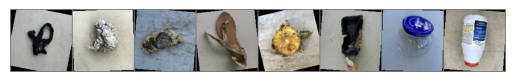

Predicted: ['Textile Trash', 'Metal', 'Food Organics', 'Textile Trash', 'Food Organics', 'Plastic', 'Glass', 'Metal']
Actual:    ['Textile Trash', 'Metal', 'Food Organics', 'Textile Trash', 'Food Organics', 'Plastic', 'Glass', 'Plastic']


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images + predictions
imshow(torchvision.utils.make_grid(images[:8]))
print("Predicted:", [dataset.classes[i] for i in predicted[:8]])
print("Actual:   ", [dataset.classes[i] for i in labels[:8]])


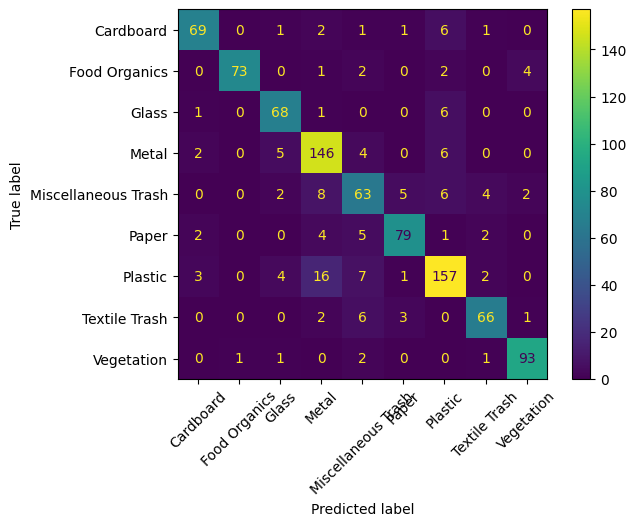

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(xticks_rotation=45)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'resnet_realwaste_best.pth')

In [ ]:
from google.colab import files
files.download('resnet_realwaste_best.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>